In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import emcee
import pdb

In [4]:
fluxes = pd.read_csv('../data/fluxes.txt', delim_whitespace=True)

In [5]:
fluxes = fluxes.sort_values('S1400', ascending=False)
y_obs = fluxes['S1400'] # mJy
log_y_obs = np.log(y_obs)
y_err = fluxes['err']
Smin_obs = y_obs.min()
n = len(fluxes)
Sdiff_obs = 5.2

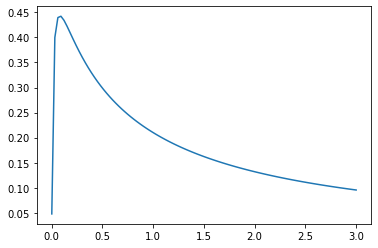

In [164]:
plt.plot(np.linspace(0.001, 3, 101), lognorm(-1.1, .9, 0.001, 3))
plt.xlabel("Flux Density [mJy]")
plt.ylabel()

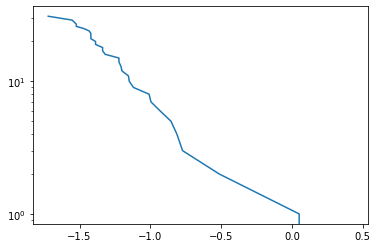

In [10]:
plt.semilogy(log_y_obs, np.arange(n))
plt.semilogy()

In [18]:
from scipy.special import erfc, comb

In [7]:
def calc_pobs(Smin, mu, sig):
    return min(0.5 * erfc((np.log10(Smin) - mu) / (np.sqrt(2) * sig)), 1 - 1e-15)


In [8]:
def exception_handler(func):
    def inner_function(*args, **kwargs):
        try:
            func(*args, **kwargs)
        except:
            pdb.set_trace()
    return inner_function

In [9]:
def logL_obs(params, log_y_obs):
    mu, sig, Smin, N = params
    pobs = calc_pobs(Smin, mu, sig)
    n = len(log_y_obs)
    return np.log((1 / (pobs * sig * np.sqrt(2)*np.pi)))* n + np.sum(-(log_y_obs - mu) **2 / (2 * sig ** 2))

def logL_N(params):
    mu, sig, Smin, N = params
    pobs = calc_pobs(Smin, mu, sig)
    n = len(log_y_obs)
    return np.log(comb(N, n)) + n * np.log(pobs) + (N-n) * np.log(1 - pobs) 

def logL_diff(params):
    mu, sig, Smin, N = params
    Sexp = 10 ** (mu + 0.5 * sig ** 2 * np.log(10))
    Sdiff = N * Sexp
    sigdiff = np.sqrt(N) * Sexp * np.sqrt(10 ** (sig ** 2 * np.log(10)) - 1)
    return np.log(1 / (sigdiff * np.sqrt(2 * np.pi))) + (-(Sdiff_obs - Sdiff) ** 2 / (2 * sigdiff ** 2))

def log_prob(params, log_y_obs, cov):
    mu, sig, Smin, N = params
    prior = pmu.pdf(mu) * psig.pdf(sig) * pSmin.pdf(Smin) * pN.pdf(N)
    # prior = (1 / 3) * (1 / 1.4) * (1 / Smin_obs) * (1 / (500 - len(log_y_obs)))
    if prior == 0:
        return -np.inf
    return logL_obs(params, log_y_obs) * logL_N(params) * logL_diff(params) + np.log(prior)
    
# def log_prob(pa rams, mean, cov):
#     return np.log(norm.)

In [48]:
from scipy.stats import norm, uniform

In [49]:
pmu = uniform(-4.5 , 5)
psig = uniform(0.2, 1.5)
pSmin = uniform(0.000001, Smin_obs)
pN = uniform(n, 500 - n)
pr = norm(5.5, 0.9)

In [70]:
def get_init(nwalkers=10, seed=0):
    np.random.seed(seed)
    init = [pmu.rvs(nwalkers), psig.rvs(nwalkers), pSmin.rvs(nwalkers), np.array([int(x) for x in pN.rvs(nwalkers)])]
    return np.array([[-3.1, .9, .013, 60]] * nwalkers) * (1 + np.random.random((nwalkers, ndim)) / 5)
    # return np.transpose(np.array(init))


In [71]:
import emcee
ndim = 4
nwalkers = 10
cov=[]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[log_y_obs, cov],    
                                moves=[(emcee.moves.DEMove(), 0.8),
                                       (emcee.moves.DESnookerMove(), 0.2),
                                      ]
                               )

In [72]:
p0 = get_init(nwalkers=nwalkers)

In [73]:
state = sampler.run_mcmc(p0, 1000)


In [74]:
sampler.reset()

In [75]:
sampler.run_mcmc(state, 10000)

State([[-4.49999922e+00  2.00000042e-01  1.90008322e-02  3.20000792e+01]
 [-4.49999972e+00  2.00000270e-01  1.90008873e-02  3.20000542e+01]
 [-4.49999851e+00  2.00000110e-01  1.90009463e-02  3.20000301e+01]
 [-4.49999919e+00  2.00000122e-01  1.90009283e-02  3.20001945e+01]
 [-4.49999657e+00  2.00000023e-01  1.90009344e-02  3.20001163e+01]
 [-4.49999877e+00  2.00000122e-01  1.90009832e-02  3.20000918e+01]
 [-4.49999947e+00  2.00000110e-01  1.90009243e-02  3.20000985e+01]
 [-4.49999919e+00  2.00000003e-01  1.90009506e-02  3.20006890e+01]
 [-4.49999962e+00  2.00000011e-01  1.90006892e-02  3.20001770e+01]
 [-4.49999946e+00  2.00000191e-01  1.90007953e-02  3.20000316e+01]], log_prob=[6.63074923e+15 6.63074390e+15 6.63075682e+15 6.63073887e+15
 6.63067751e+15 6.63076360e+15 6.63077171e+15 6.63066539e+15
 6.63070118e+15 6.63072419e+15], blobs=None, random_state=('MT19937', array([ 847144792,  662298691, 2373619063, 3207176326, 1256837109,
       2658631699, 3498849581, 4029156438, 3866389911,

In [76]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.096


In [77]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [791.08923536 900.58349302 818.10280415 960.64754011]

In [ ]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=1000)
labels = ["mu", "sig", "Smin", "N"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [115]:
sampler.get_chain()[:, 2,:]

array([[-2.49705112e+00,  8.00491290e-01,  1.89133393e-02,
         2.11355463e+02],
       [-2.49732371e+00,  8.00384481e-01,  1.89079441e-02,
         2.12115084e+02],
       [-2.49732371e+00,  8.00384481e-01,  1.89079441e-02,
         2.12115084e+02],
       ...,
       [-2.49957054e+00,  8.12195362e-01,  1.89144580e-02,
         2.08169493e+02],
       [-2.49957054e+00,  8.12195362e-01,  1.89144580e-02,
         2.08169493e+02],
       [-2.49951721e+00,  8.11878884e-01,  1.89190625e-02,
         2.08962790e+02]])

(90000, 4)


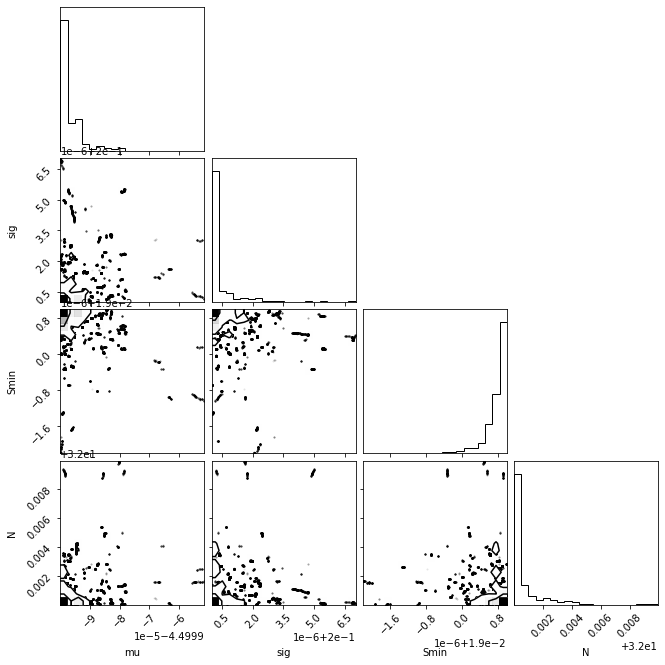

In [69]:
flat_samples = sampler.get_chain(flat=True, discard=1000)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels
);

In [73]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [401.33796417 274.98979751 271.23766359 298.3473282 ]

In [25]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

(100000, 4)


In [26]:
trimmed = np.array([flat_samples[i] for i in range(100000) if flat_samples[i][3] < 350])

In [27]:
trimmed.shape

(84116, 4)

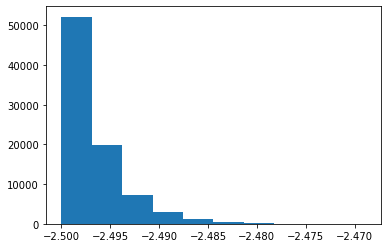

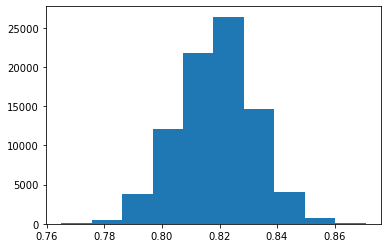

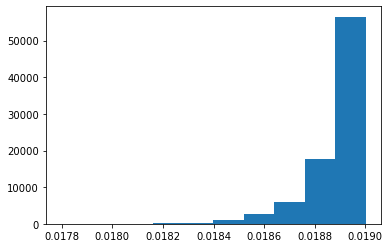

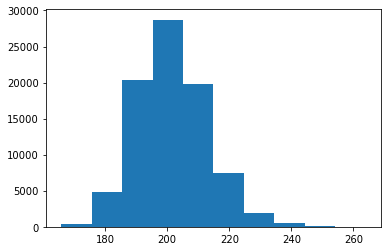

In [28]:
for ii in range(ndim):
    plt.hist(trimmed[:,ii])
    plt.show()

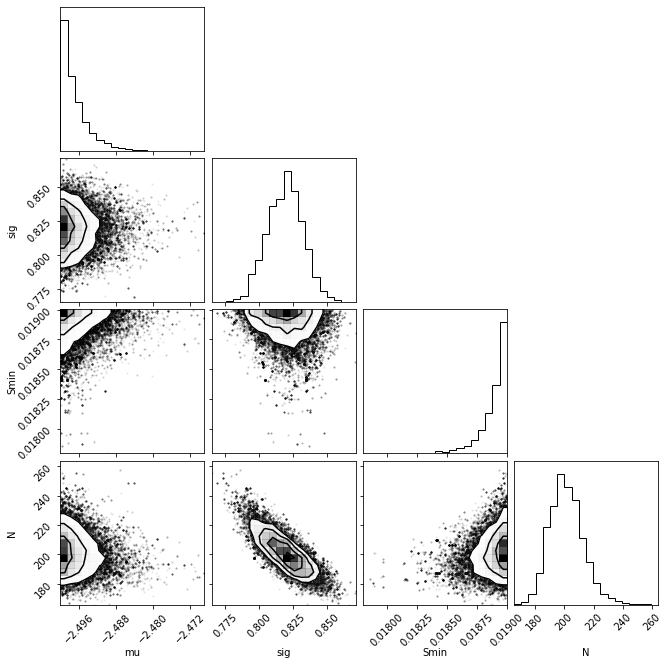

In [29]:
import corner

fig = corner.corner(
    trimmed, labels=labels
);

In [226]:
print(logL_diff(p0[66]))
print(logL_obs(p0[66], log_y_obs))
print(logL_N(p0[66]))

-642.0988613726574
-2738.730291707896
-inf


<ipython-input-179-7839d57d0868>:11: RuntimeWarning: divide by zero encountered in log
  return np.log(comb(N, n)) + n * np.log(pobs) + (N-n) * np.log(1 - pobs)


In [28]:
ptest = get_init(1000)

In [30]:
for ii in range(len(ptest)):
    
    print(logL(ptest[ii], log_y_obs, cov))

-2435.236513142134
-43902714.99224571
-11889.382063924459
-10445.772213537386
-957999.577688317
-2114.9194720074534
-4551.798994106694
-977406.4592901415
-210663.83805499467
-4494.085891711417
-2132.282665659417
-506106.45045660675
-17796.056513221647
-55068.41065017032
-89688804.46757796
-20.157427217206024
-106.05073440428936
-740573.3213743106
-14709.604691246694
-6916.991796765113
-4300908.509325113
-12235.151056812585
-4999.4691470360785
-14750.451183058722
-1074.7278904489424
-15718.675848587036
-65.49179139812296
-128903.08422511014
-7960.76700221603
-288645.7304886257
-822.3264179915794
-9155656.803598246
-2035.550464049175
-3266.525582967769
-12.88780828790858
-18456.174324504445
-6659.791871381141
-980.7247698631542
-1463949.6603970395
-13065.206419264436
-35115.07235870427
-9984.921539605934
-15249.931925795305
-71.49672639271512
-3849212.31401924
-10452.000669350273
-536.2191760134615
-1059.920071090005
-97.90946844430731
-6283.529381809742
-5880.842969225332
-1915943.25123

-991.0562126399717
-324437.00626314967
-112.71652131190837
-1708.78054465494
-148180.41934452436
-21.85459795431666
-188.14744401012922
-7249.252236752865
-1049.6920644711488
-2253.6721207922233
-497915.311348301
-83.94774352123233
-7230.456126846549
-51732.69019485077
-164224.5514855964
-8661.39109746732
-1759.9927943400965
-12049.148966620787
-9250.216728693136
-7837.2975999160535
-654.4479878566841
-7661.6849184607145
-303.372628970609
-3793.9221477268347
-1203.7692565246077
-394614.17421344225
-936.0349013734242
-22535.106188812
-6943.456918138783
-848.4917893298862
-37475.049689135194
-6296.724233216614
-122.47556587826176
-115186927.8250584
-41660.71888521163
-3918.5784344070476
-27457.234856119576
-3097456.9896394666
-1703964.2166272947
-21884.974279847494
-137056.0253680927
-35305.34081225842
-39.963207770728864
-342.8280784343469
-4259.693805779519
-3846281.3195290607
-2353710.613334257
-908.1255958455021
-26838.038597970837
-517.9388543499133
-11084.950241558456
-2000.3644876

In [165]:
for ii in range(len(p0)):
    
    print(logL(p0[ii], log_y_obs))

--Return--
None
> <ipython-input-159-f8f9f18ba40e>(6)inner_function()
      3         try:
      4             func(*args, **kwargs)
      5         except:
----> 6             pdb.set_trace()
      7     return inner_function

ipdb> p0
array([[-8.53559488e-01,  1.30841505e+00,  1.85947485e-02,
         1.55000000e+02],
       [-3.54431901e-01,  9.40452888e-01,  1.51850127e-02,
         3.94000000e+02],
       [-6.91709872e-01,  9.95262386e-01,  8.76910788e-03,
         2.45000000e+02],
       [-8.65350451e-01,  1.49583529e+00,  1.48310543e-02,
         2.98000000e+02],
       [-1.22903560e+00,  2.99450481e-01,  2.24821409e-03,
         4.00000000e+01],
       [-5.62317661e-01,  3.21981020e-01,  1.21594994e-02,
         3.21000000e+02],
       [-1.18723837e+00,  2.28305756e-01,  2.72471246e-03,
         3.18000000e+02],
       [ 1.75319002e-01,  1.36566778e+00,  1.79497094e-02,
         3.20000000e+02],
       [ 3.90988282e-01,  1.28941945e+00,  9.91611811e-03,
         4.73000000e+02]

BdbQuit: 

In [105]:
logL_obs(params, log_y_obs) * logL_N(params) * logL_diff(params) 

-1169.146378987846

Text(0.5, 1.0, 'Params: $mu$=-1.5, $sigma$=0.9, Smin=0.019mJy, N=50')

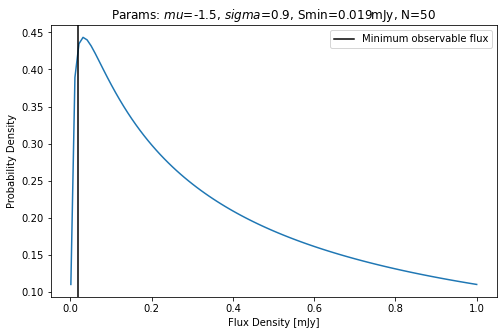

In [188]:
def lognorm(mu, sig, ll, uu):
    x = np.linspace(ll, uu, 101)
    return 1/(np.sqrt(2 * np.pi) * sig) * np.exp(-(np.log10(x) - mu)**2 / (2 * sig**2))

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.001, 1, 101), lognorm(-1.5, .9, 0.001, 1))
plt.axvline(Smin_obs, color='k', label='Minimum observable flux')
plt.xlabel("Flux Density [mJy]")
plt.ylabel("Probability Density")
plt.legend()
plt.title(r"Params: $mu$={}, $sigma$={}, Smin=0.019mJy, N={}".format(-1.5, .9, 50))

In [193]:
from scipy.stats import lognorm

In [186]:
test.pdf(np.linspace(0.001, 1, 101))

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

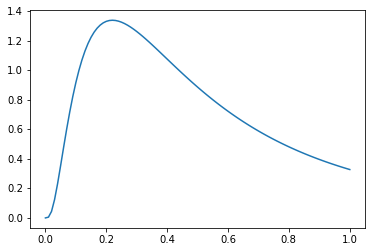

In [196]:
test= lognorm(s=.9, scale=np.exp(-.7))
plt.plot(np.linspace(0.001, 1, 101), test.pdf(np.linspace(0.001, 1, 101)))

In [206]:
log_y_obs

0     0.988053
1     0.118672
13   -1.180908
3    -1.777857
12   -1.870803
11   -1.966113
19   -2.145581
10   -2.292635
7    -2.322788
2    -2.577022
9    -2.645075
8    -2.659260
14   -2.764621
4    -2.780621
20   -2.813411
27   -2.813411
25   -3.036554
6    -3.079114
21   -3.079114
22   -3.194183
31   -3.194183
18   -3.270169
15   -3.270169
28   -3.270169
24   -3.296837
26   -3.381395
23   -3.506558
5    -3.506558
17   -3.540459
29   -3.575551
16   -3.772261
30   -3.963316
Name: S1400, dtype: float64

(1, 100)

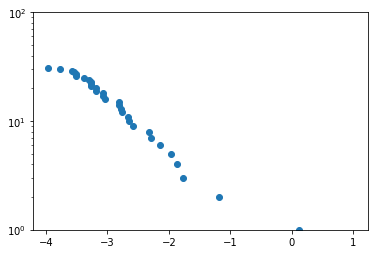

In [210]:
plt.scatter(log_y_obs, np.arange(n))
plt.yscale('log')
plt.ylim([1, 100])

(1, 100)

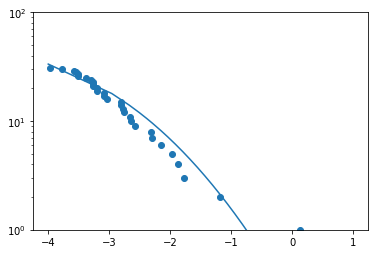

In [242]:
test= lognorm(s=3, scale=np.exp(-7.9))
plt.scatter(log_y_obs, np.arange(n))
plt.plot(np.log10(np.linspace(0.0001, 1, 1001)), 50*(1- test.cdf(np.linspace(0.0001, 1, 1001))))
plt.yscale('log')
plt.ylim([1, 100])


Text(0.5, 1.0, 'Params: $mu$=-1.5, $sigma$=9, Smin=0.019mJy, N=200')

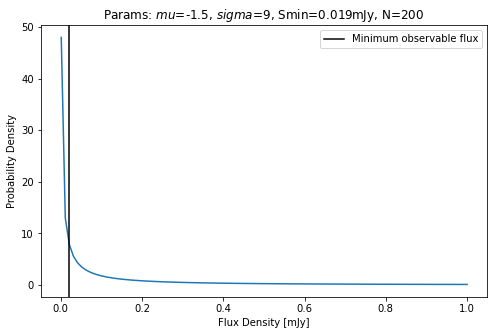

In [182]:
plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.001, 1, 101), 200 * lognorm(-4, 1.1, 0.001, 1))
plt.axvline(Smin_obs, color='k', label='Minimum observable flux')
plt.xlabel("Flux Density [mJy]")
plt.ylabel("Probability Density")
plt.legend()
plt.title(r"Params: $mu$={}, $sigma$={}, Smin=0.019mJy, N={}".format(-1.5, 9, 200))

-2.497827838809718

In [42]:
mu, sig, Smin, N = np.median(trimmed[:,0]), np.median(trimmed[:,1]), np.median(trimmed[:,2]), np.median(trimmed[:,3])

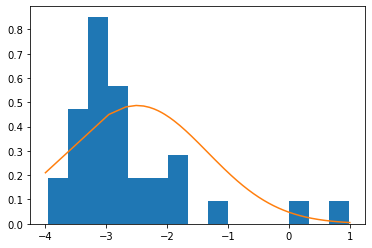

In [46]:
plt.hist(log_y_obs, bins=15, density=True)
xs = np.log10(np.linspace(0.0001, 10, 10000))
plt.plot(xs, norm(mu, sig, xs))

In [43]:
def norm(mu,sig, xs):
    return 1/(np.sqrt(2*np.pi) * sig) * np.exp(-(mu - xs)**2 / (2*sig)**2)